In [2]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


In [3]:
data = pd.read_csv("emails.csv",encoding = "'latin'")

In [4]:
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [6]:
data["text"] = data.text
data["spam"] = data.spam
data["text"][0]

"Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  ma

Splitting data

In [5]:
from sklearn.model_selection import train_test_split
emails_train, emails_test, target_train, target_test = train_test_split(data.text,data.spam,test_size = 0.2) 

In [6]:
data.info

<bound method DataFrame.info of                                                    text  spam
0     Subject: naturally irresistible your corporate...     1
1     Subject: the stock trading gunslinger  fanny i...     1
2     Subject: unbelievable new homes made easy  im ...     1
3     Subject: 4 color printing special  request add...     1
4     Subject: do not have money , get software cds ...     1
...                                                 ...   ...
5723  Subject: re : research and development charges...     0
5724  Subject: re : receipts from visit  jim ,  than...     0
5725  Subject: re : enron case study update  wow ! a...     0
5726  Subject: re : interest  david ,  please , call...     0
5727  Subject: news : aurora 5 . 2 update  aurora ve...     0

[5728 rows x 2 columns]>

In [10]:
emails_test.shape

(1146,)

# Preprocessing

In [10]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

x_train[0]

'subject eprm  vince     could you please provide me with an indication on whether you will be able  to review the latest eprm article in the next day or so      look forward to hearing from you shortly     julie'

In [11]:
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [16]:
x_train# test_y

['subject eprm  vince     could you please provide me with an indication on whether you will be able  to review the latest eprm article in the next day or so      look forward to hearing from you shortly     julie',
 'subject you want some outright sex  don  t you   free prescription and viagra overnight delivery   http    qxi  dagohevoa  d  hwd  dmshushhb  com  as he thinks in his heart  so he is   only those who dare to fail greatly can ever achieve greatly   he  s simply got the instinct for being unhappy highly developed',
 'subject encounter article  shalesh ganjoo  we have conducted an interview and written the attached article for the  upcoming edition of the encounter  the associate  analyst programs   newsletter  the interview was conducted with shalesh ganjoo in regards to  his participation with the implementation of storage capacity as a  commodity   to ensure our publication is printing the most accurate information  i have  attached the article for your review  please con

# Tokenize

In [19]:
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [20]:
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


[14,
 184,
 3861,
 8,
 35,
 601,
 6,
 47,
 5465,
 8,
 971,
 2,
 18,
 7,
 200,
 497,
 723,
 1,
 114,
 21,
 37,
 947,
 37,
 479,
 280,
 53,
 10,
 93,
 571,
 598,
 529,
 1257,
 102,
 489,
 167,
 156,
 62,
 83,
 566,
 10,
 32]

# Padding

In [21]:
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([  0,   0,   0, ..., 566,  10,  32], dtype=int32)

# Model

In [22]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model

In [23]:
# create the model
import tensorflow as tf
embedding_vecor_length = 32

model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 32)          1600000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
______________________________________________

In [24]:
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_data=(x_test_features, test_y))
model.save('spam_model.h5')

Epoch 1/20
9/9 [==============================] - 214s 23s/step - loss: 0.6748 - accuracy: 0.7058 - val_loss: 0.6348 - val_accuracy: 0.7723
Epoch 2/20
9/9 [==============================] - 163s 18s/step - loss: 0.5839 - accuracy: 0.7584 - val_loss: 0.5238 - val_accuracy: 0.7723
Epoch 3/20
9/9 [==============================] - 166s 19s/step - loss: 0.5377 - accuracy: 0.7584 - val_loss: 0.5129 - val_accuracy: 0.7723
Epoch 4/20
9/9 [==============================] - 167s 19s/step - loss: 0.4920 - accuracy: 0.7584 - val_loss: 0.4221 - val_accuracy: 0.7723
Epoch 5/20
9/9 [==============================] - 168s 19s/step - loss: 0.3330 - accuracy: 0.8023 - val_loss: 0.2252 - val_accuracy: 0.9424
Epoch 6/20
9/9 [==============================] - 166s 19s/step - loss: 0.2042 - accuracy: 0.9734 - val_loss: 0.2023 - val_accuracy: 0.9599
Epoch 7/20
9/9 [==============================] - 163s 18s/step - loss: 0.3662 - accuracy: 0.9282 - val_loss: 0.9279 - val_accuracy: 0.7723
Epoch 8/20
9/9 [====

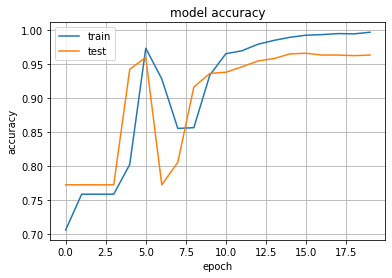

In [25]:
from  matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()


In [26]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

In [32]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]
cf_matrix =confusion_matrix(test_y,y_predict)
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

36/36 [==============================] - 17s 425ms/step
Precision: 95.82%
Recall: 87.74%
F1 Score: 91.60%


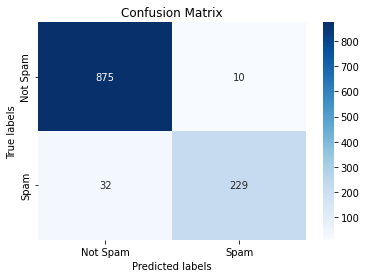

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);